## **Model Prototyping**

This notebook builds and evaluates initial text classification models  
to detect spoiler vs non-spoiler reviews.

Baseline models tested:
- Multinomial Naive Bayes
- Logistic Regression


In [1]:
import nltk
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score, f1_score
from scipy.sparse import hstack, csr_matrix
from sklearn.metrics import precision_recall_fscore_support
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt
import os, torch
from dataclasses import dataclass
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from transformers import (BertTokenizerFast, BertForSequenceClassification,
                          DataCollatorWithPadding, get_linear_schedule_with_warmup)
from transformers import TrainingArguments, Trainer
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
import joblib

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

/home/electronic/Downloads/plot-protector-bert_testing/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /home/electronic/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/electronic/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/electronic/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
df = pd.read_feather("../data/preprocessed_reviews.feather")

### Adding Features
- `has_spoiler_tag`
- `full_text`

In [3]:
df["full_text"] = df["original_review_summary"] + " " + df["original_review_text"]
df["has_spoiler_tag"] = df["review_text"].apply(lambda x : "spoiler" in x)

### Splitting the data for training and testing

In [4]:
X = df[["full_text", "has_spoiler_tag", "review_text_ner"]]
y = df["is_spoiler"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_text = X_train["full_text"]
X_test_text = X_test["full_text"]
y_test = y_test.astype(str)

In [5]:
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])
print("Spoiler ratio (train):", y_train.value_counts(normalize=True))

Training samples: 459130
Testing samples: 114783
Spoiler ratio (train): is_spoiler
False    0.737027
True     0.262973
Name: proportion, dtype: float64


In [6]:
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    return " ".join(lemmatizer.lemmatize(w) for w in text.split())

X_train_clean_text = [clean_text(t) for t in X_train_text]
X_test_clean_text = [clean_text(t) for t in X_test_text]

### Vectorizing the `full_text` column

In [7]:
tfidf_full = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,2),
    min_df=3,
    max_df=0.8,
    sublinear_tf=True,
    stop_words='english'
)

X_train_tfidf = tfidf_full.fit_transform(X_train_clean_text)
X_test_tfidf = tfidf_full.transform(X_test_clean_text)

In [8]:
keywords = [
    "plot twist", "ending", "spoiler", "die", "surprise", "reveal", "betrayal",
    "twist", "kill", "death", "betray",
    "secret", "hidden truth", "big reveal", "unexpected", "shocking", "truth come out",
    "turn out", "actually", "real identity", "mask off", "double life", "deception",
    "disguise", "undercover", "false", "pretend", "plot reveal", "confession",
    "murder", "die in the end", "sacrifice", "fatal", "tragic end",
    "last scene", "final moment", "shot", "poison", "accident", "suicide",
    "dead", "death scene", "funeral", "grave",
    "turn against", "double cross", "traitor", "backstab", "deceive", "lie",
    "set up", "frame", "sell out", "enemy", "betrayal arc",
    "finale", "ending explain", "last episode", "climax", "final battle",
    "resolution", "conclusion", "credit scene", "after credit", "final twist",
    "mind blowing", "psychological", "hallucination", "dream", "illusion", "impostor",
    "gaslight", "paradox", "memory loss", "not real", "imagine", "alternate reality",
    "simulation", "hidden motive", "true story", "cover up", "reveal all", "plot uncovered",
    "secret revealed", "truth revealed", "twist ending", "unexpected ending",
    "major twist", "final reveal", "plot expose", "truth exposed",
    "identity reveal", "mask reveal", "real face", "truth behind", "dark secret",
    "hidden agenda", "big secret", "truth uncovered", "plot leak", "spoiler alert",
    "plot summary", "hidden clue", "truth discovered", "unmask", "truth behind the scenes",
    "ending reveal", "real story", "real meaning", "twist plot", "deceptive plot",
    "it was all a dream", "everything was fake", "alternate timeline", "fake death",
    "he never existed", "she never existed", "was alive", "alive after all",
    "they faked it", "time travel", "loop", "flashback", "false memory",
    "misdirection", "unreliable narrator", "true villain", "unexpected killer",
    "it was him", "it was her", "plot uncovered", "truth revealed",
    "the big twist", "turn of events", "revealed later", "flashforward",
    "time skip", "he returns", "she returns", "back from dead"
]

In [12]:
lemmatized_keywords = set([clean_text(k) for k in keywords])

In [13]:
tfidf_kw = TfidfVectorizer(
    vocabulary=lemmatized_keywords,
    ngram_range=(1, 3),
    lowercase=True
)
X_train_kw = tfidf_kw.fit_transform(X_train_clean_text)
X_test_kw = tfidf_kw.transform(X_test_clean_text)

### Putting everything together

In [14]:
X_train_numeric = X_train[["has_spoiler_tag"]].copy()
X_train_numeric["has_spoiler_tag"] = X_train_numeric["has_spoiler_tag"].astype(int)

X_test_numeric = X_test[["has_spoiler_tag"]].copy()
X_test_numeric["has_spoiler_tag"] = X_test_numeric["has_spoiler_tag"].astype(int)

In [16]:
X_train_combined = hstack([
    X_train_tfidf,
    X_train_kw,
    csr_matrix(X_train_numeric.values)
])

X_test_combined = hstack([
    X_test_tfidf,
    X_test_kw,
    csr_matrix(X_test_numeric.values)
])

## **Training with Naive Bayes**

In [17]:
param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]}
grid = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='f1')
grid.fit(X_train_combined, y_train)
print(grid.best_params_)

{'alpha': 0.01}


In [18]:
nb = MultinomialNB(alpha=grid.best_params_['alpha'])
nb.fit(X_train_combined, y_train)
nb_probs = nb.predict_proba(X_test_combined)[:, 1]

In [19]:
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred = (nb_probs >= t).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(y_test.map({'False':0,'True':1}), y_pred, average='binary', zero_division=np.nan)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1-Score: {best_f1:.4f}")


Best Threshold: 0.25
Best F1-Score: 0.5293


              precision    recall  f1-score   support

       False       0.85      0.73      0.79     84598
        True       0.46      0.63      0.53     30185

    accuracy                           0.70    114783
   macro avg       0.65      0.68      0.66    114783
weighted avg       0.74      0.70      0.72    114783



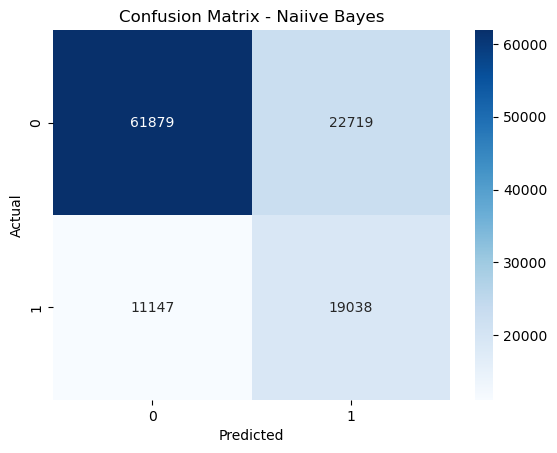

In [20]:
y_pred = np.where(nb_probs > best_threshold, 'True', 'False')

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Naiive Bayes")
plt.show()

In [21]:
precision_nb, recall_nb, f1_nb, _ = precision_recall_fscore_support(
    y_test.map({'False': 0, 'True': 1}),
    (y_pred == 'True').astype(int),
    average='binary',
    zero_division=np.nan
)
accuracy_nb = accuracy_score(y_test, y_pred)
macro_f1_nb = f1_score(y_test, y_pred, average='macro')

## **Training with Logistic Regression**

In [22]:
lr = LogisticRegression(
    max_iter=100,
    class_weight='balanced',
    solver='saga',
    n_jobs=-1
)
lr.fit(X_train_combined, y_train)
lr_probs = lr.predict_proba(X_test_combined)[:, 1]

In [ ]:
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred = (lr_probs >= t).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(y_test.map({'False':0,'True':1}), y_pred, average='binary', zero_division=np.nan)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1-Score: {best_f1:.4f}")

Best Threshold: 0.51
Best F1-Score: 0.5599


              precision    recall  f1-score   support

       False       0.86      0.76      0.81     84598
        True       0.49      0.65      0.56     30185

    accuracy                           0.73    114783
   macro avg       0.68      0.71      0.68    114783
weighted avg       0.76      0.73      0.74    114783



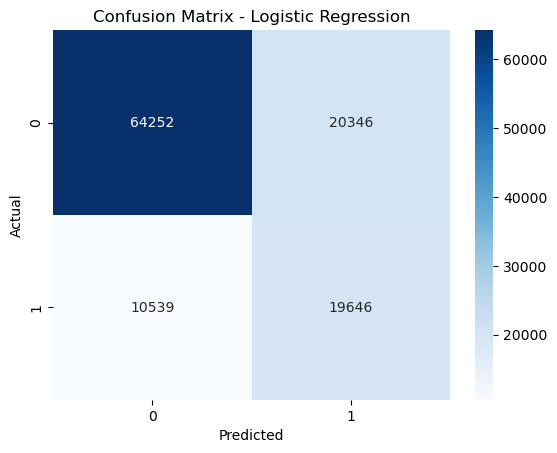

In [24]:
y_pred = np.where(lr_probs > best_threshold, 'True', 'False')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [25]:
precision_lr, recall_lr, f1_lr, _ = precision_recall_fscore_support(
    y_test.map({'False': 0, 'True': 1}),
    (y_pred == 'True').astype(int),
    average='binary',
    zero_division=np.nan
)
accuracy_lr = accuracy_score(y_test, y_pred)
macro_f1_lr = f1_score(y_test, y_pred, average='macro')

### **Comparing both the results**

In [26]:
results = pd.DataFrame({
    'Model': ['Naive Bayes', 'Logistic Regression'],
    'Precision (Spoiler)': [round(precision_nb, 2), round(precision_lr,2)],
    'Recall (Spoiler)': [round(recall_nb,2), round(recall_lr,2)],
    'F1 (Spoiler)': [round(f1_nb,2), round(f1_lr,2)],
    'Accuracy': [round(accuracy_nb,2), round(accuracy_lr,2)],
    'Macro F1': [round(macro_f1_nb,2), round(macro_f1_lr,2)]
})

results

,Model,Precision (Spoiler),Recall (Spoiler),F1 (Spoiler),Accuracy,Macro F1
0,Naive Bayes,0.46,0.63,0.53,0.70,0.66
1,Logistic Regression,0.49,0.65,0.56,0.73,0.68


## **BERT**

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
@dataclass
class BERTCfg:
    model_name: str = "bert-base-uncased"
    max_length: int = 256       
    train_bs: int = 32          # Increased from 16
    eval_bs: int = 64           # Increased from 32
    lr: float = 3e-5            # Learning rate
    weight_decay: float = 0.01
    epochs: int = 8             # Target epochs
    warmup_ratio: float = 0.06
    gradient_accumulation_steps: int = 2  # Effective batch size = 64
    fp16: bool = True           # Mixed precision
    dataloader_num_workers: int = 4  # Parallel loading
    gradient_checkpointing: bool = True  # Save memory
    outdir: str = "../models/bert"

cfg = BERTCfg()
os.makedirs(cfg.outdir, exist_ok=True)

print("Configuration:")
print(f"  Model: {cfg.model_name}")
print(f"  Max length: {cfg.max_length}")
print(f"  Batch size: {cfg.train_bs} (effective: {cfg.train_bs * cfg.gradient_accumulation_steps})")
print(f"  Learning rate: {cfg.lr}")
print(f"  Epochs: {cfg.epochs}")
print(f"  Mixed precision: {cfg.fp16}")
print(f"  Gradient checkpointing: {cfg.gradient_checkpointing}")

Configuration:
  Model: bert-base-uncased
  Max length: 256
  Batch size: 32 (effective: 64)
  Learning rate: 3e-05
  Epochs: 8
  Mixed precision: True
  Gradient checkpointing: True


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    # Clear cache
    torch.cuda.empty_cache()
else:
    print("⚠️  WARNING: CUDA not available. Training will be very slow on CPU!")

Using device: cuda
GPU: NVIDIA RTX 4500 Ada Generation
CUDA Version: 12.8
Available GPU memory: 25.39 GB


In [5]:
plit_dir = "../data/bert"

print("Loading data...")
train_df = pd.read_csv(f"../data/bert/train.csv")
val_df = pd.read_csv(f"../data/bert/val.csv")
test_df = pd.read_csv(f"../data/bert/test.csv")

print(f"✓ Train size: {len(train_df):,}")
print(f"✓ Val size: {len(val_df):,}")
print(f"✓ Test size: {len(test_df):,}")

# Load or create label encoder
try:
    le_spoiler = joblib.load(f"../data/bert/label_encoder.joblib")
    print("✓ Label encoder loaded")
except:
    print("Creating label encoder...")
    le_spoiler = LabelEncoder().fit(
        pd.concat([train_df["label"], val_df["label"], test_df["label"]])
    )
    joblib.dump(le_spoiler, f"../data/bert/label_encoder.joblib")
    print("✓ Label encoder created and saved")

# Display class distribution
print("\nClass distribution in training set:")
print(train_df["label"].value_counts())
print(f"\nClass balance: {train_df['label'].value_counts(normalize=True)}")


Loading data...
✓ Train size: 459,130
✓ Val size: 57,391
✓ Test size: 57,392
✓ Label encoder loaded

Class distribution in training set:
label
0    338391
1    120739
Name: count, dtype: int64

Class balance: label
0    0.737027
1    0.262973
Name: proportion, dtype: float64


/home/electronic/Downloads/plot-protector-bert_testing/.venv/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
class SpoilerDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        """
        Optimized dataset for BERT training.
        
        Args:
            texts: List or Series of text strings
            labels: List or Series of integer labels
            tokenizer: BERT tokenizer
            max_length: Maximum sequence length
        """
        self.texts = [str(t) for t in texts]
        self.labels = labels.astype(int).tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        # Tokenization happens here, cached by DataLoader workers
        enc = self.tokenizer(
            self.texts[idx], 
            truncation=True, 
            max_length=self.max_length, 
            padding=False  # Let collator handle padding for efficiency
        )
        return {
            "input_ids": enc["input_ids"],
            "attention_mask": enc["attention_mask"],
            "labels": self.labels[idx],
        }

print("✓ Dataset class defined")

✓ Dataset class defined


In [7]:
print(f"Loading tokenizer: {cfg.model_name}")
tokenizer = BertTokenizerFast.from_pretrained(cfg.model_name)

print("Creating datasets...")
train_ds = SpoilerDataset(train_df["text"], train_df["label"], tokenizer, cfg.max_length)
val_ds = SpoilerDataset(val_df["text"], val_df["label"], tokenizer, cfg.max_length)
test_ds = SpoilerDataset(test_df["text"], test_df["label"], tokenizer, cfg.max_length)

print(f"✓ Train dataset: {len(train_ds):,} samples")
print(f"✓ Val dataset: {len(val_ds):,} samples")
print(f"✓ Test dataset: {len(test_ds):,} samples")

# Test a sample
sample = train_ds[0]
print(f"\nSample data shape:")
print(f"  Input IDs: {len(sample['input_ids'])} tokens")
print(f"  Attention mask: {len(sample['attention_mask'])} tokens")
print(f"  Label: {sample['labels']}")

Loading tokenizer: bert-base-uncased
Creating datasets...
✓ Train dataset: 459,130 samples
✓ Val dataset: 57,391 samples
✓ Test dataset: 57,392 samples

Sample data shape:
  Input IDs: 256 tokens
  Attention mask: 256 tokens
  Label: 1


In [8]:
print("Creating data loaders...")

collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

train_loader = DataLoader(
    train_ds, 
    batch_size=cfg.train_bs, 
    shuffle=True, 
    collate_fn=collator,
    num_workers=cfg.dataloader_num_workers,
    pin_memory=True,
    persistent_workers=True if cfg.dataloader_num_workers > 0 else False
)

val_loader = DataLoader(
    val_ds, 
    batch_size=cfg.eval_bs, 
    shuffle=False, 
    collate_fn=collator,
    num_workers=cfg.dataloader_num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    test_ds, 
    batch_size=cfg.eval_bs, 
    shuffle=False, 
    collate_fn=collator,
    num_workers=cfg.dataloader_num_workers,
    pin_memory=True
)

print(f"✓ Train loader: {len(train_loader):,} batches")
print(f"✓ Val loader: {len(val_loader):,} batches")
print(f"✓ Test loader: {len(test_loader):,} batches")

# Test a batch
test_batch = next(iter(train_loader))
print(f"\nSample batch shape:")
print(f"  Input IDs: {test_batch['input_ids'].shape}")
print(f"  Attention mask: {test_batch['attention_mask'].shape}")
print(f"  Labels: {test_batch['labels'].shape}")

Creating data loaders...
✓ Train loader: 14,348 batches
✓ Val loader: 897 batches
✓ Test loader: 897 batches


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable 


Sample batch shape:
  Input IDs: torch.Size([32, 256])
  Attention mask: torch.Size([32, 256])
  Labels: torch.Size([32])


TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [9]:
print(f"Loading model: {cfg.model_name}")

num_labels = len(le_spoiler.classes_) if hasattr(le_spoiler, "classes_") else 2
model = BertForSequenceClassification.from_pretrained(
    cfg.model_name, 
    num_labels=num_labels
).to(device)

# Enable gradient checkpointing to save memory
if cfg.gradient_checkpointing:
    model.gradient_checkpointing_enable()
    print("✓ Gradient checkpointing enabled")

# Calculate class weights for balanced training
cls_counts = train_df["label"].value_counts().sort_index().values
cls_weights = (cls_counts.sum() / (num_labels * cls_counts))
cls_weights = torch.tensor(cls_weights, dtype=torch.float, device=device)

print(f"✓ Model loaded with {num_labels} output classes")
print(f"✓ Class weights: {cls_weights.cpu().numpy()}")
print(f"✓ Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"✓ Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Loading model: bert-base-uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Gradient checkpointing enabled
✓ Model loaded with 2 output classes
✓ Class weights: [0.6784016 1.9013326]
✓ Model parameters: 109,483,778
✓ Trainable parameters: 109,483,778


In [10]:
print("Setting up optimizer and scheduler...")

optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=cfg.lr, 
    weight_decay=cfg.weight_decay
)

total_steps = cfg.epochs * len(train_loader) // cfg.gradient_accumulation_steps
num_warmup = int(cfg.warmup_ratio * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=num_warmup, 
    num_training_steps=total_steps
)

# Mixed precision scaler
scaler = GradScaler(enabled=cfg.fp16)

# Loss function with class weights
criterion = torch.nn.CrossEntropyLoss(weight=cls_weights)

print(f"✓ Optimizer: AdamW (lr={cfg.lr}, weight_decay={cfg.weight_decay})")
print(f"✓ Scheduler: Linear with warmup")
print(f"  - Total steps: {total_steps:,}")
print(f"  - Warmup steps: {num_warmup:,}")
print(f"✓ Loss: CrossEntropyLoss with class weights")
print(f"✓ Mixed precision (FP16): {cfg.fp16}")

Setting up optimizer and scheduler...
✓ Optimizer: AdamW (lr=3e-05, weight_decay=0.01)
✓ Scheduler: Linear with warmup
  - Total steps: 57,392
  - Warmup steps: 3,443
✓ Loss: CrossEntropyLoss with class weights
✓ Mixed precision (FP16): True


/tmp/ipykernel_3540/872867173.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=cfg.fp16)


In [51]:
# from torch.optim import AdamW
# optimizer = AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
# total_steps = cfg.epochs * len(train_loader)
# num_warmup = int(cfg.warmup_ratio * total_steps)
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup, num_training_steps=total_steps)

In [11]:
def train_one_epoch_optimized(epoch):
    """
    Train for one epoch with optimizations:
    - Mixed precision training (FP16)
    - Gradient accumulation
    - Progress tracking
    """
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    optimizer.zero_grad()
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{cfg.epochs}")
    for step, batch in enumerate(pbar):
        # Move batch to GPU with non_blocking for speed
        batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
        
        # Mixed precision forward pass
        with autocast(enabled=cfg.fp16):
            outputs = model(
                input_ids=batch["input_ids"], 
                attention_mask=batch["attention_mask"]
            )
            loss = criterion(outputs.logits, batch["labels"])
            # Scale loss for gradient accumulation
            loss = loss / cfg.gradient_accumulation_steps
        
        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        
        # Accumulate metrics
        total_loss += loss.item() * cfg.gradient_accumulation_steps
        preds = outputs.logits.argmax(1)
        correct += (preds == batch["labels"]).sum().item()
        total += batch["labels"].size(0)
        
        # Update weights every gradient_accumulation_steps
        if (step + 1) % cfg.gradient_accumulation_steps == 0:
            # Unscale gradients and clip
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            # Step optimizer and scheduler
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()
        
        # Update progress bar
        current_loss = loss.item() * cfg.gradient_accumulation_steps
        current_acc = correct / total
        pbar.set_postfix({
            'loss': f'{current_loss:.4f}',
            'acc': f'{current_acc:.4f}',
            'lr': f'{scheduler.get_last_lr()[0]:.2e}'
        })
    
    return total_loss / len(train_loader), correct / total

print("✓ Training function defined")

✓ Training function defined


In [12]:
@torch.no_grad()
def evaluate_optimized(loader, desc="Eval"):
    """
    Evaluate model on given data loader.
    Returns loss, accuracy, F1 score, and predictions.
    """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    pbar = tqdm(loader, desc=desc)
    for batch in pbar:
        batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
        
        # Mixed precision inference
        with autocast(enabled=cfg.fp16):
            outputs = model(
                input_ids=batch["input_ids"], 
                attention_mask=batch["attention_mask"],
                labels=batch["labels"]
            )
        
        loss = outputs.loss
        logits = outputs.logits
        
        total_loss += loss.item() * batch["labels"].size(0)
        preds = logits.argmax(1)
        correct += (preds == batch["labels"]).sum().item()
        total += batch["labels"].size(0)
        
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(batch["labels"].cpu().tolist())
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / total
    accuracy = correct / total
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    
    return avg_loss, accuracy, f1_macro, (all_labels, all_preds)

print("✓ Evaluation function defined")

✓ Evaluation function defined


In [13]:
print("\n" + "="*70)
print("STARTING OPTIMIZED TRAINING")
print("="*70)
print(f"Device: {device}")
print(f"Epochs: {cfg.epochs}")
print(f"Batch size: {cfg.train_bs} (effective: {cfg.train_bs * cfg.gradient_accumulation_steps})")
print(f"Learning rate: {cfg.lr}")
print(f"Mixed precision (FP16): {cfg.fp16}")
print(f"Gradient checkpointing: {cfg.gradient_checkpointing}")
print(f"Total training steps: {total_steps:,}")
print(f"Output directory: {cfg.outdir}")
print("="*70 + "\n")

# Track metrics
train_losses, val_losses = [], []
train_accs, val_accs, val_f1s = [], [], []
best_val_f1 = 0

import time
start_time = time.time()

for epoch in range(1, cfg.epochs + 1):
    epoch_start = time.time()
    
    print(f"\n{'='*70}")
    print(f"Epoch {epoch}/{cfg.epochs}")
    print('='*70)
    
    # Train
    train_loss, train_acc = train_one_epoch_optimized(epoch)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc, val_f1, _ = evaluate_optimized(val_loader, desc="Validation")
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)
    
    epoch_time = time.time() - epoch_start
    
    # Print results
    print(f"\nEpoch {epoch} Results:")
    print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")
    print(f"  Time: {epoch_time/60:.2f} minutes")
    
    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_path = os.path.join(cfg.outdir, "best_model")
        os.makedirs(best_model_path, exist_ok=True)
        model.save_pretrained(best_model_path)
        tokenizer.save_pretrained(best_model_path)
        print(f"  ✓ New best model saved! (F1: {best_val_f1:.4f})")
    
    # Save checkpoint every 2 epochs
    if epoch % 2 == 0:
        checkpoint_path = os.path.join(cfg.outdir, f"checkpoint_epoch_{epoch}")
        os.makedirs(checkpoint_path, exist_ok=True)
        model.save_pretrained(checkpoint_path)
        print(f"  ✓ Checkpoint saved at epoch {epoch}")
    
    # Clear cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

total_time = time.time() - start_time

print("\n" + "="*70)
print("TRAINING COMPLETE")
print("="*70)
print(f"Total time: {total_time/3600:.2f} hours ({total_time/60:.2f} minutes)")
print(f"Average time per epoch: {total_time/cfg.epochs/60:.2f} minutes")
print(f"Best validation F1: {best_val_f1:.4f}")


STARTING OPTIMIZED TRAINING
Device: cuda
Epochs: 8
Batch size: 32 (effective: 64)
Learning rate: 3e-05
Mixed precision (FP16): True
Gradient checkpointing: True
Total training steps: 57,392
Output directory: ../models/bert


Epoch 1/8


Epoch 1/8:   0%|          | 0/14348 [00:00<?, ?it/s]/tmp/ipykernel_3540/1591389224.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=cfg.fp16):
Validation:   0%|          | 0/897 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got 


Epoch 1 Results:
  Train - Loss: 0.5706, Acc: 0.6993
  Val   - Loss: 0.5082, Acc: 0.7448, F1: 0.6931
  Time: 36.39 minutes
  ✓ New best model saved! (F1: 0.6931)

Epoch 2/8


Epoch 2/8:   0%|          | 0/14348 [00:00<?, ?it/s]/tmp/ipykernel_3540/1591389224.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=cfg.fp16):
Validation:   0%|          | 0/897 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got 


Epoch 2 Results:
  Train - Loss: 0.5129, Acc: 0.7463
  Val   - Loss: 0.5193, Acc: 0.7385, F1: 0.6952
  Time: 36.56 minutes
  ✓ New best model saved! (F1: 0.6952)
  ✓ Checkpoint saved at epoch 2

Epoch 3/8


Epoch 3/8:   0%|          | 0/14348 [00:00<?, ?it/s]/tmp/ipykernel_3540/1591389224.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=cfg.fp16):
Validation:   0%|          | 0/897 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got 


Epoch 3 Results:
  Train - Loss: 0.4391, Acc: 0.7940
  Val   - Loss: 0.5600, Acc: 0.7356, F1: 0.6891
  Time: 36.39 minutes

Epoch 4/8


Epoch 4/8:   0%|          | 0/14348 [00:00<?, ?it/s]/tmp/ipykernel_3540/1591389224.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=cfg.fp16):
Validation:   0%|          | 0/897 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got 


Epoch 4 Results:
  Train - Loss: 0.3358, Acc: 0.8533
  Val   - Loss: 0.5832, Acc: 0.7590, F1: 0.6963
  Time: 36.42 minutes
  ✓ New best model saved! (F1: 0.6963)
  ✓ Checkpoint saved at epoch 4

Epoch 5/8


Epoch 5/8:   0%|          | 0/14348 [00:00<?, ?it/s]/tmp/ipykernel_3540/1591389224.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=cfg.fp16):
Validation:   0%|          | 0/897 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got 


Epoch 5 Results:
  Train - Loss: 0.2380, Acc: 0.9029
  Val   - Loss: 0.7088, Acc: 0.7554, F1: 0.6897
  Time: 36.21 minutes

Epoch 6/8


Epoch 6/8:   0%|          | 0/14348 [00:00<?, ?it/s]/tmp/ipykernel_3540/1591389224.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=cfg.fp16):
Validation:   0%|          | 0/897 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got 


Epoch 6 Results:
  Train - Loss: 0.1655, Acc: 0.9366
  Val   - Loss: 0.8826, Acc: 0.7638, F1: 0.6885
  Time: 36.21 minutes
  ✓ Checkpoint saved at epoch 6

Epoch 7/8


Epoch 7/8:   0%|          | 0/14348 [00:00<?, ?it/s]/tmp/ipykernel_3540/1591389224.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=cfg.fp16):
Validation:   0%|          | 0/897 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got 


Epoch 7 Results:
  Train - Loss: 0.1161, Acc: 0.9581
  Val   - Loss: 1.0395, Acc: 0.7633, F1: 0.6882
  Time: 36.12 minutes

Epoch 8/8


Epoch 8/8:   0%|          | 0/14348 [00:00<?, ?it/s]/tmp/ipykernel_3540/1591389224.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=cfg.fp16):
Validation:   0%|          | 0/897 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got 


Epoch 8 Results:
  Train - Loss: 0.0859, Acc: 0.9711
  Val   - Loss: 1.1946, Acc: 0.7660, F1: 0.6876
  Time: 36.12 minutes
  ✓ Checkpoint saved at epoch 8

TRAINING COMPLETE
Total time: 4.84 hours (290.47 minutes)
Average time per epoch: 36.31 minutes
Best validation F1: 0.6963


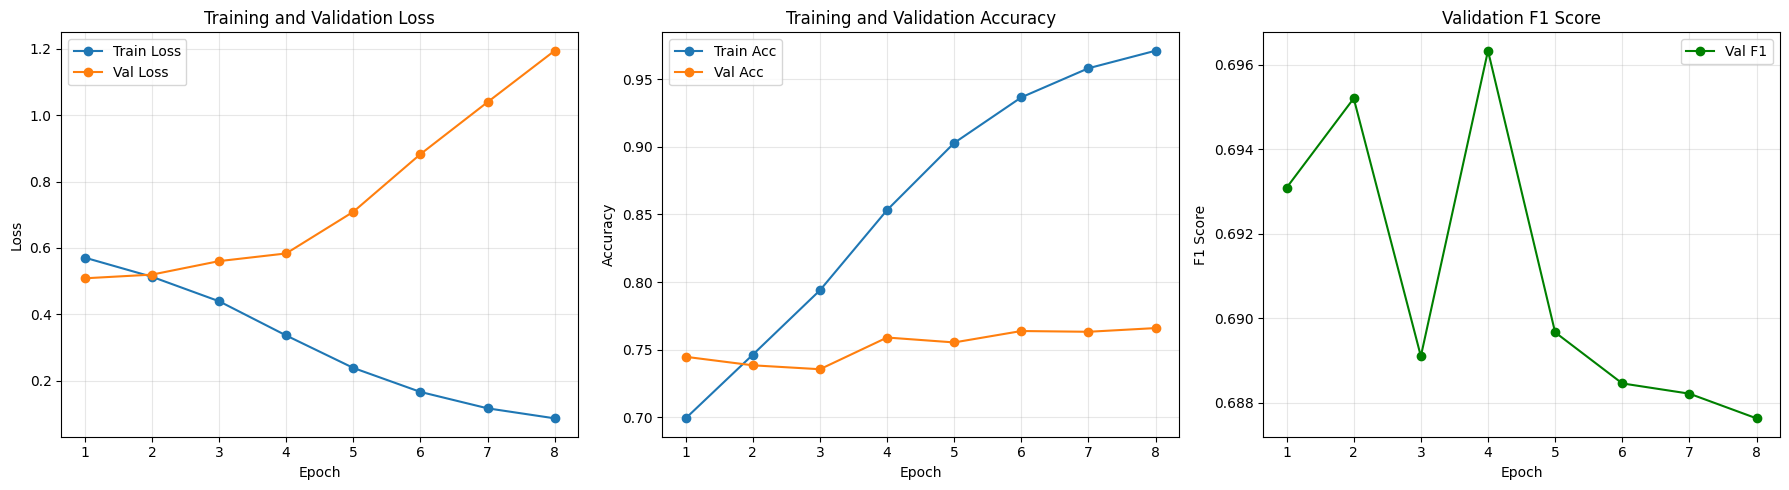

✓ Training metrics plot saved


In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(range(1, len(train_losses)+1), train_losses, label='Train Loss', marker='o')
axes[0].plot(range(1, len(val_losses)+1), val_losses, label='Val Loss', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(range(1, len(train_accs)+1), train_accs, label='Train Acc', marker='o')
axes[1].plot(range(1, len(val_accs)+1), val_accs, label='Val Acc', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# F1 Score
axes[2].plot(range(1, len(val_f1s)+1), val_f1s, label='Val F1', marker='o', color='green')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('Validation F1 Score')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(cfg.outdir, 'training_metrics.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✓ Training metrics plot saved")


In [15]:
print("\n" + "="*70)
print("EVALUATING ON TEST SET")
print("="*70 + "\n")

# Load best model
print("Loading best model...")
best_model = BertForSequenceClassification.from_pretrained(
    os.path.join(cfg.outdir, "best_model")
).to(device)
model = best_model  # Replace current model with best model

print("Evaluating...")
test_loss, test_acc, test_f1, (y_true, y_pred) = evaluate_optimized(
    test_loader, 
    desc="Test"
)

print(f"\nTest Results:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  F1 (macro): {test_f1:.4f}")


EVALUATING ON TEST SET

Loading best model...
Evaluating...


Test:   0%|          | 0/897 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELIS


Test Results:
  Loss: 0.5814
  Accuracy: 0.7565
  F1 (macro): 0.6941


In [16]:
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70 + "\n")

print(classification_report(y_true, y_pred, target_names=['Non-Spoiler', 'Spoiler']))

# Calculate detailed metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, average=None
)

metrics_df = pd.DataFrame({
    'Class': ['Non-Spoiler', 'Spoiler'],
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\nDetailed Metrics:")
print(metrics_df.to_string(index=False))


CLASSIFICATION REPORT

              precision    recall  f1-score   support

 Non-Spoiler       0.85      0.82      0.83     42299
     Spoiler       0.53      0.58      0.56     15093

    accuracy                           0.76     57392
   macro avg       0.69      0.70      0.69     57392
weighted avg       0.76      0.76      0.76     57392


Detailed Metrics:
      Class  Precision   Recall  F1-Score  Support
Non-Spoiler   0.845310 0.819570  0.832241    42299
    Spoiler   0.534094 0.579673  0.555951    15093



CONFUSION MATRIX

[[34667  7632]
 [ 6344  8749]]


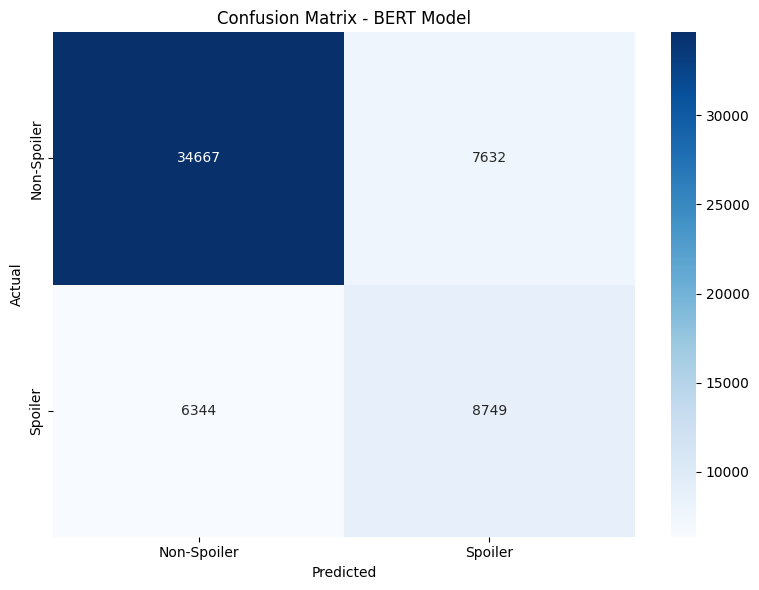

✓ Confusion matrix plot saved


In [17]:
print("\n" + "="*70)
print("CONFUSION MATRIX")
print("="*70 + "\n")

cm = confusion_matrix(y_true, y_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=['Non-Spoiler', 'Spoiler'],
    yticklabels=['Non-Spoiler', 'Spoiler']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - BERT Model')
plt.tight_layout()
plt.savefig(os.path.join(cfg.outdir, 'confusion_matrix.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix plot saved")

In [18]:
final_path = os.path.join(cfg.outdir, "final")
os.makedirs(final_path, exist_ok=True)

print(f"Saving final model to: {final_path}")
model.save_pretrained(final_path)
tokenizer.save_pretrained(final_path)

try:
    joblib.dump(le_spoiler, os.path.join(final_path, "label_encoder.joblib"))
    print("✓ Label encoder saved")
except:
    print("⚠️  Could not save label encoder")

# Save training history
history = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accs': train_accs,
    'val_accs': val_accs,
    'val_f1s': val_f1s,
    'test_loss': test_loss,
    'test_acc': test_acc,
    'test_f1': test_f1,
    'config': {
        'model_name': cfg.model_name,
        'max_length': cfg.max_length,
        'train_bs': cfg.train_bs,
        'lr': cfg.lr,
        'epochs': cfg.epochs,
    }
}

import json
with open(os.path.join(cfg.outdir, 'training_history.json'), 'w') as f:
    json.dump(history, f, indent=2)

print("✓ Training history saved")
print(f"\n✓ All files saved to: {cfg.outdir}")

Saving final model to: ../models/bert/final
✓ Label encoder saved
✓ Training history saved

✓ All files saved to: ../models/bert


In [19]:
print("\n" + "="*70)
print("TRAINING SUMMARY")
print("="*70 + "\n")

print("Model Configuration:")
print(f"  Architecture: {cfg.model_name}")
print(f"  Max sequence length: {cfg.max_length}")
print(f"  Number of labels: {num_labels}")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")

print("\nTraining Configuration:")
print(f"  Epochs: {cfg.epochs}")
print(f"  Batch size: {cfg.train_bs}")
print(f"  Effective batch size: {cfg.train_bs * cfg.gradient_accumulation_steps}")
print(f"  Learning rate: {cfg.lr}")
print(f"  Weight decay: {cfg.weight_decay}")
print(f"  Mixed precision: {cfg.fp16}")
print(f"  Gradient checkpointing: {cfg.gradient_checkpointing}")

print("\nTraining Results:")
print(f"  Total training time: {total_time/3600:.2f} hours")
print(f"  Best validation F1: {best_val_f1:.4f}")
print(f"  Final training loss: {train_losses[-1]:.4f}")
print(f"  Final validation loss: {val_losses[-1]:.4f}")
print(f"  Final training accuracy: {train_accs[-1]:.4f}")
print(f"  Final validation accuracy: {val_accs[-1]:.4f}")

print("\nTest Set Results:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  F1 Score (macro): {test_f1:.4f}")
print(f"  Precision (Spoiler): {precision[1]:.4f}")
print(f"  Recall (Spoiler): {recall[1]:.4f}")
print(f"  F1 Score (Spoiler): {f1[1]:.4f}")

print("\n" + "="*70)
print("TRAINING COMPLETE - ALL RESULTS SAVED")
print("="*70)


TRAINING SUMMARY

Model Configuration:
  Architecture: bert-base-uncased
  Max sequence length: 256
  Number of labels: 2
  Total parameters: 109,483,778

Training Configuration:
  Epochs: 8
  Batch size: 32
  Effective batch size: 64
  Learning rate: 3e-05
  Weight decay: 0.01
  Mixed precision: True
  Gradient checkpointing: True

Training Results:
  Total training time: 4.84 hours
  Best validation F1: 0.6963
  Final training loss: 0.0859
  Final validation loss: 1.1946
  Final training accuracy: 0.9711
  Final validation accuracy: 0.7660

Test Set Results:
  Loss: 0.5814
  Accuracy: 0.7565
  F1 Score (macro): 0.6941
  Precision (Spoiler): 0.5341
  Recall (Spoiler): 0.5797
  F1 Score (Spoiler): 0.5560

TRAINING COMPLETE - ALL RESULTS SAVED



MODEL COMPARISON

              Model  Precision (Spoiler)  Recall (Spoiler)  F1 (Spoiler)  Accuracy  F1 (Macro)
        Naive Bayes             0.460000          0.630000      0.530000  0.700000    0.660000
Logistic Regression             0.490000          0.650000      0.560000  0.730000    0.680000
               BERT             0.534094          0.579673      0.555951  0.756482    0.694096


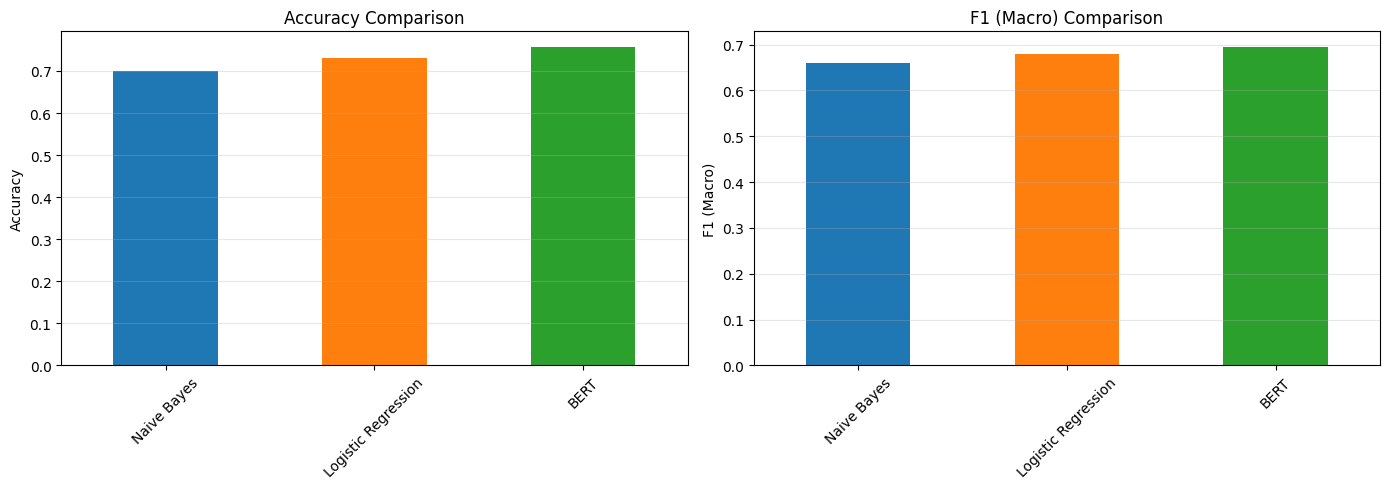

✓ Model comparison plot saved


In [20]:
comparison_df = pd.DataFrame({
    'Model': ['Naive Bayes', 'Logistic Regression', 'BERT'],
    'Precision (Spoiler)': [0.46, 0.49, precision[1]],
    'Recall (Spoiler)': [0.63, 0.65, recall[1]],
    'F1 (Spoiler)': [0.53, 0.56, f1[1]],
    'Accuracy': [0.70, 0.73, test_acc],
    'F1 (Macro)': [0.66, 0.68, test_f1]
})

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70 + "\n")
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

metrics = ['Accuracy', 'F1 (Macro)']
for idx, metric in enumerate(metrics):
    comparison_df.plot(
        x='Model', 
        y=metric, 
        kind='bar', 
        ax=axes[idx],
        legend=False,
        color=['#1f77b4', '#ff7f0e', '#2ca02c']
    )
    axes[idx].set_ylabel(metric)
    axes[idx].set_xlabel('')
    axes[idx].set_title(f'{metric} Comparison')
    axes[idx].set_xticklabels(comparison_df['Model'], rotation=45)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(cfg.outdir, 'model_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✓ Model comparison plot saved")

In [21]:
def predict_spoiler(text, model, tokenizer, device, max_length=256):
    """
    Predict whether a given text contains spoilers.
    
    Args:
        text: Input text string
        model: Trained BERT model
        tokenizer: BERT tokenizer
        device: torch device
        max_length: Maximum sequence length
    
    Returns:
        Dictionary with prediction and probability
    """
    model.eval()
    
    # Tokenize
    encoding = tokenizer(
        text,
        truncation=True,
        max_length=max_length,
        padding='max_length',
        return_tensors='pt'
    )
    
    # Move to device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()
        confidence = probs[0][pred_class].item()
    
    return {
        'text': text,
        'prediction': 'Spoiler' if pred_class == 1 else 'Non-Spoiler',
        'confidence': confidence,
        'probabilities': {
            'Non-Spoiler': probs[0][0].item(),
            'Spoiler': probs[0][1].item()
        }
    }

# Test on sample texts
sample_texts = [
    "This movie was amazing! Great acting and beautiful cinematography.",
    "The ending was shocking when the main character died saving everyone.",
    "I loved every minute of this film. Highly recommended!",
    "Bruce Willis was dead the whole time in The Sixth Sense.",
    "The plot twist at the end completely changed everything!",
]

print("\n" + "="*70)
print("TESTING INFERENCE ON SAMPLE TEXTS")
print("="*70 + "\n")

for text in sample_texts:
    result = predict_spoiler(text, model, tokenizer, device, cfg.max_length)
    print(f"Text: {result['text']}")
    print(f"Prediction: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.4f}")
    print(f"Probabilities: Non-Spoiler={result['probabilities']['Non-Spoiler']:.4f}, "
          f"Spoiler={result['probabilities']['Spoiler']:.4f}")
    print("-" * 70 + "\n")



TESTING INFERENCE ON SAMPLE TEXTS

Text: This movie was amazing! Great acting and beautiful cinematography.
Prediction: Non-Spoiler
Confidence: 0.9974
Probabilities: Non-Spoiler=0.9974, Spoiler=0.0026
----------------------------------------------------------------------

Text: The ending was shocking when the main character died saving everyone.
Prediction: Spoiler
Confidence: 0.9709
Probabilities: Non-Spoiler=0.0291, Spoiler=0.9709
----------------------------------------------------------------------

Text: I loved every minute of this film. Highly recommended!
Prediction: Non-Spoiler
Confidence: 0.9989
Probabilities: Non-Spoiler=0.9989, Spoiler=0.0011
----------------------------------------------------------------------

Text: Bruce Willis was dead the whole time in The Sixth Sense.
Prediction: Non-Spoiler
Confidence: 0.9187
Probabilities: Non-Spoiler=0.9187, Spoiler=0.0813
----------------------------------------------------------------------

Text: The plot twist at the end com

In [22]:
print("\n" + "="*70)
print("ANALYZING MISCLASSIFIED EXAMPLES")
print("="*70 + "\n")

# Get misclassified indices
y_true_array = np.array(y_true)
y_pred_array = np.array(y_pred)
misclassified_idx = np.where(y_true_array != y_pred_array)[0]

print(f"Total misclassified: {len(misclassified_idx)} out of {len(y_true)} "
      f"({len(misclassified_idx)/len(y_true)*100:.2f}%)")

# Analyze false positives (predicted spoiler but was not)
false_positives = np.where((y_true_array == 0) & (y_pred_array == 1))[0]
print(f"\nFalse Positives: {len(false_positives)}")

# Analyze false negatives (predicted non-spoiler but was spoiler)
false_negatives = np.where((y_true_array == 1) & (y_pred_array == 0))[0]
print(f"False Negatives: {len(false_negatives)}")

# Show some examples
if len(false_positives) > 0:
    print("\nExample False Positives (predicted Spoiler, actually Non-Spoiler):")
    for i in false_positives[:3]:  # Show first 3
        text = test_df.iloc[i]['text']
        print(f"  - {text[:200]}...")  # Show first 200 chars
        print()

if len(false_negatives) > 0:
    print("\nExample False Negatives (predicted Non-Spoiler, actually Spoiler):")
    for i in false_negatives[:3]:  # Show first 3
        text = test_df.iloc[i]['text']
        print(f"  - {text[:200]}...")  # Show first 200 chars
        print()


ANALYZING MISCLASSIFIED EXAMPLES

Total misclassified: 13976 out of 57392 (24.35%)

False Positives: 7632
False Negatives: 6344

Example False Positives (predicted Spoiler, actually Non-Spoiler):
  - An expensive piece of degrading tripe One of the worst written, vulgar, rude and distasteful movies to come along in a long time. I squirmed in my chair all the way through this waste of good actors.....

  - Christmas in the real world. Even though it was a few days after Christmas, I decided to stay in the spirit and watch a Christmas movie. When I saw the cast, I figured it had to be a good movie. As I ...

  - Not a bad adaptation at all, just lacking something... It is said that behind greed, vengeance is the purest human emotion. The desire to inflict pain on those that wronged you is the driving force be...


Example False Negatives (predicted Non-Spoiler, actually Spoiler):
  - Inspired silliness and some good jokes The celebrated Roger Ebert, in his review of Zoolander  written 

In [23]:

# Uncomment if you want attention visualizations (requires bertviz)
!pip install bertviz

from bertviz import head_view

def visualize_attention(text, model, tokenizer, device):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', truncation=True, max_length=256)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_attentions=True
        )
    
    attention = outputs.attentions  # Tuple of attention weights for each layer
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    
    # Visualize attention for all layers
    head_view(attention, tokens)

# Example usage:
sample_text = "The twist ending revealed that the killer was the detective all along."
visualize_attention(sample_text, model, tokenizer, device)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


<IPython.core.display.Javascript object>